In [1]:
from analytics import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
p = Path("/projects/RL-fold/msalim/production-runs/pasc/")
experiment_dir = p/"bba_28_cs1.2"
reference_path = Path("/projects/RL-fold/msalim/SC20-GB-CS1-ThetaGPU-AI-driven-MD/data/1FME/1FME-folded.pdb")
data = analyze_md_runs(
    experiment_dir,
    reference_path,
    select="protein and name CA",
    cutoff=8.0,
    in_memory=True,
)

16227it [23:07, 11.69it/s]


In [54]:
import json
json_save = Path(".").resolve().joinpath("contact_rmsd.json")
#with open(json_save, "w") as f:
#    json.dump(data, f)

In [3]:
import json
json_save = Path("..").resolve().joinpath("contact_rmsd.json")
with open(json_save, "r") as f:
    data = json.load(f)

In [4]:
from collections import defaultdict
def gather_data(data):
    iteration_data = defaultdict(list)
    for md_run_data in data:
        run_iter = Path(md_run_data[0]["dcd_file"]).with_suffix("").name.split("_")[1]
        iteration_data[run_iter].extend(md_run_data)

    # {run_iter(000001): [[dicts]]}
    return iteration_data

In [5]:
gathered_data = gather_data(data)

In [6]:
rmsd_stats = defaultdict(list)
contact_stats = defaultdict(list)
import pandas as pd

for iteration_data in gathered_data.values():
    
    df = pd.DataFrame(iteration_data)
    
    rmsd_stats["Mean"].append(df.rmsd.mean())
    rmsd_stats["Min"].append(df.rmsd.min())
    rmsd_stats["Max"].append(df.rmsd.max())
    
    contact_stats["Mean"].append(df.contact.mean())
    contact_stats["Min"].append(df.contact.min())
    contact_stats["Max"].append(df.contact.max())
    

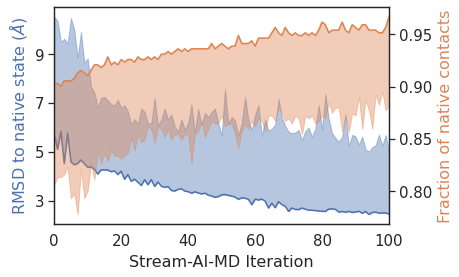

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
X = list(range(len(rmsd_stats["Min"])))

l1 = ax.plot(rmsd_stats["Min"], color=C1, label="RMSD")
ax.fill_between(X, rmsd_stats["Min"], rmsd_stats["Max"], color=C1, alpha=0.4)
ax.set_ylabel("RMSD to native state ($\\AA$)", color=C1)

l2 = ax2.plot(contact_stats["Max"], color=C2, label="Contact Fraction")
ax2.fill_between(X, contact_stats["Min"], contact_stats["Max"], color=C2, alpha=0.4)
ax2.set_ylabel("Fraction of native contacts", color=C2)

ax.set_xlabel("Stream-AI-MD Iteration")
ax.set_xlim(0,100)
ax2.set_xlim(0,100)
ax.set_yticks([3,5,7,9])

lines = l1 + l2
labels = [l.get_label() for l in lines]
save_fig("combined_timeseries_bba_28_cs1.2")

In [23]:
rmsd_df = pd.DataFrame(rmsd_stats)
contact_df = pd.DataFrame(contact_stats)

rmsd_df.plot(
    ylabel=r"RMSD to native state $(\AA)$",
    xlabel="Stream-AI-MD iteration",
)
plt.legend(facecolor=LEGEND_FACECOLOR)
rmsd_df.describe()
save_fig("rmsd_timeseries_bba_28_cs1.2")

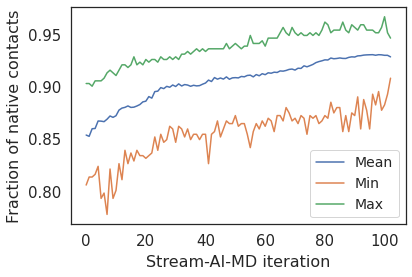

In [25]:
contact_df.plot(
    ylabel=r"Fraction of native contacts",
    xlabel="Stream-AI-MD iteration",
)
plt.legend(facecolor=LEGEND_FACECOLOR)
contact_df.describe()
save_fig("contact_timeseries_bba_28_cs1.2")

# Get best PDBs

In [4]:
import json
json_save = Path(".").resolve().joinpath("contact_rmsd.json")
with open(json_save, "r") as f:
    data = json.load(f)

In [20]:
# Get lowest RMSD
best_rmsd_conformer = min(
    itertools.chain(*data),
    key=lambda x: x["rmsd"],
)

# Get largest fraction of native contacts
best_contact_conformer = max(
    itertools.chain(*data),
    key=lambda x: x["contact"],
)

In [21]:
best_rmsd_conformer

{'rmsd': 2.4320826733213172,
 'contact': 0.9464285714285714,
 'frame': 162,
 'pdb_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0085_000095/run0047_000092__system__198.pdb',
 'dcd_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0085_000095/run0085_000095.dcd'}

In [23]:
best_contact_conformer

{'rmsd': 3.6960150191427883,
 'contact': 0.9668367346938775,
 'frame': 119,
 'pdb_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0049_000101/run0040_000099__system__33.pdb',
 'dcd_file': '/projects/RL-fold/msalim/production-runs/pasc/bba_28_cs1.2/md_runs/run0049_000101/run0049_000101.dcd'}

In [35]:
here = Path("/lus/theta-fs0/projects/RL-fold/braceal/src/PASC21-Stream-AI-MD/")

write_pdb(
    output_pdb=here.joinpath("pdbs/bba/1FME_best_rmsd.pdb").as_posix(),
    input_pdb=best_rmsd_conformer["pdb_file"],
    traj_file=best_rmsd_conformer["dcd_file"],
    frame=best_rmsd_conformer["frame"],
)

write_pdb(
    output_pdb=here.joinpath("pdbs/bba/1FME_best_contact.pdb").as_posix(),
    input_pdb=best_contact_conformer["pdb_file"],
    traj_file=best_contact_conformer["dcd_file"],
    frame=best_contact_conformer["frame"],
)

# Analysis

In [6]:
len(data)

16227

In [9]:
all_data = list(itertools.chain(*data))

In [10]:
len(all_data)

3245400

In [11]:
import pandas as pd
df = pd.DataFrame(all_data)

<AxesSubplot:>

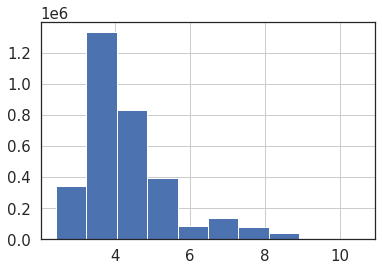

In [19]:
df.rmsd.hist()

<AxesSubplot:>

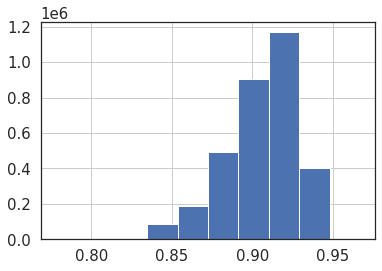

In [14]:
df.contact.hist()

In [15]:
df.describe()

,rmsd,contact,frame
count,3.245400e+06,3.245400e+06,3.245400e+06
mean,4.344925e+00,9.053796e-01,9.950000e+01
std,1.154731e+00,2.216527e-02,5.773431e+01
min,2.432083e+00,7.780612e-01,0.000000e+00
25%,3.584449e+00,8.928571e-01,4.975000e+01
50%,4.014561e+00,9.081633e-01,9.950000e+01
75%,4.754805e+00,9.209184e-01,1.492500e+02
max,1.053684e+01,9.668367e-01,1.990000e+02


<AxesSubplot:>

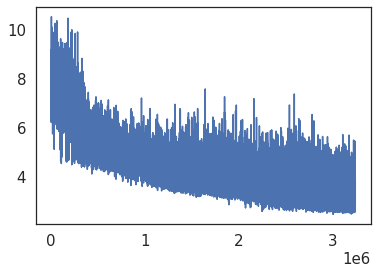

In [16]:
df.rmsd.plot()

<AxesSubplot:>

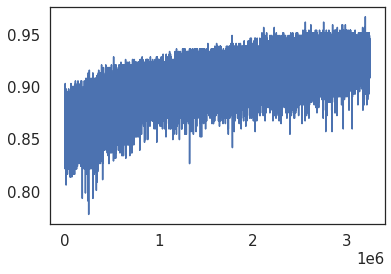

In [17]:
df.contact.plot()